In [1]:
import sys
import os
import math
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt  # To visualize
import numpy as np
from sklearn import mixture
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Get folder location from args
print(str(sys.argv[0]))
#base_directory = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment1/attempt2/'
#base_directory = '/home/jeanpierre/libra2/libra2/experiments_logs/hpc_logs/attempt10-8machines'
base_directory = '/home/jeanpierre/Desktop/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment1/attempt1'


#Processing the folders in order
experiment_type = []
experiment_type_part1 = []
experiment_type_part2 = []

for dir_name in os.listdir(base_directory):
    experiment_type_part1.append(int(dir_name.split('_')[0]))
    experiment_type_part2.append(str(dir_name.split('_')[1]))

experiment_type_part1.sort()
for dir_nr in range(len(experiment_type_part1)):
    experiment_type.append(str(experiment_type_part1[dir_nr]) + "_" + experiment_type_part2[dir_nr])

tmp_frames = [[],[],[],[]]
data_frames = []
for dir_name in experiment_type:
    for experiment_folder in os.listdir(base_directory + "/" + dir_name):
        tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal.csv", names=["txns", "duration"]))
        #tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_mempool_process_incoming_transactions.csv", names=["txns", "duration"]))
        tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_new_round.csv", names=["txns", "duration", "timeout_round", "timestamp"]))
        tmp_frames[2].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_ensure_round_and_sync_up.csv", names=["txns", "duration"]))
        tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_without_sync.csv", names=["txns", "duration"]))

    #Only take the log data for 1000 transactions
    for i in range(len(tmp_frames)):
        for j in range(len(tmp_frames[i])):
            tmp_frames[i][j] = tmp_frames[i][j][tmp_frames[i][j]['txns'] == max(tmp_frames[i][j]['txns'])]
    
    #merge the files
    for frames in tmp_frames:
        data_frames.append(pd.concat(frames))
    
    tmp_frames = [[],[],[],[]]
        
              
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    data_frames[i] = data_frames[i]
    i += 1

print("#entries(0):", len(data_frames[0]))
print("#entries(1):", len(data_frames[1]))
print("#entries(2):", len(data_frames[2]))
print("#entries(3):", len(data_frames[3]))
print("#entries(3):", len(data_frames[4]))
print(len(data_frames))

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py
#entries(0): 2243
#entries(1): 1122
#entries(2): 2243
#entries(3): 2243
#entries(3): 3923
60


In [4]:
def get_dist_parameters(index, calculate_round_sync_percentage):
    data = data_frames[index]['duration']
    data = data[data >= 40]
    
    percentage = 1
    if calculate_round_sync_percentage:
        percentage = 1 - ((len(data_frames[index]['duration']) - len(data)) / len(data_frames[index]['duration']))
    
    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    
    #Gamma dist
    a, loc_gamma, scale_gamma = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc_gamma, scale_gamma)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #Beta dist
    alpha, beta, loc_beta, scale_beta = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc_beta, scale_beta)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)
    
    if p_gamma_fit[1] >= p_beta_fit[1]:
        sys.stdout.write("gamma:" + str(a) + ":" + str(loc_gamma) + ":" + str(scale_gamma))
    else:
        sys.stdout.write("beta:" + str(alpha) + ":" + str(beta) + ":" + str(loc_beta) + ":" + str(scale_beta))
        
    if calculate_round_sync_percentage:
        sys.stdout.write(":" + str(percentage))
        
    sample_size = int(round(5000*percentage))
    if p_gamma_fit[1] >= p_beta_fit[1]:
        return stats.gamma.rvs(a, loc_gamma, scale_gamma, size=sample_size)
    else:
        return stats.beta.rvs(alpha, beta, loc_beta, scale_beta, size=sample_size)

In [4]:
def get_mixture_multivariate_normal_distribution():
    for index in range(len(experiment_type)):
        data = data_frames[index*4 + 0]['duration']

        #Clean the data a bit
        data = data[data.between(data.quantile(0), data.quantile(.98))]
        data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
        data = data.values.reshape(-1,1)

        model = mixture.GaussianMixture(n_components=10)
        model.fit(data)

        s = '{0},{1}:'
        s_last = '{0},{1}'
        sys.stdout.write(s.format(*model.weights_))
        sys.stdout.write(s.format(*model.means_.flatten()))
        sys.stdout.write(s_last.format(*model.covariances_.flatten()))
        print()
        
        
get_mixture_multivariate_normal_distribution()

0.1632779848147534,0.12466658138691077:270.4100743330513,505.0589641592572:99.77323178847278,138.39679859561969
0.18542971244189196,0.22517479147495106:524.9918982321606,270.73766025969724:201.4775098781862,174.23544275764783
0.11037076484771553,0.20583011575577345:318.20583718946153,591.1137896601788:254.89170989426094,207.5374517641577
0.111913427776337,0.09324910123789024:547.5816179740034,334.61635198614806:727.5349308834719,266.6234053970931
0.1863069759349964,0.09752809779912457:652.3191810021865,368.5251173381044:165.51127333632715,320.07332026226493
0.22627494058043549,0.12429225774149337:743.7210667215247,406.7761298804922:228.05742701098882,835.0171154710536
0.15906570097597653,0.07987899487439203:886.4035462064303,647.0506286576938:555.8295838307225,1458.3073415813046
0.09140933199852978,0.10216803888351494:932.4241770630955,616.2928560066571:1178.6822145933704,1417.6813860818347
0.057189736171529705,0.24203862623066524:607.0519991615479,951.9665266878284:1836.0531758765978,

In [9]:
dist = 'process_proposal'

if dist == 'process_proposal':
    get_mixture_multivariate_normal_distribution()
elif dist == 'process_new_round':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 1
        get_dist_parameters(index, 0)
        print()
elif dist == 'ensure_round_and_sync_up':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 2
        get_dist_parameters(index, 1)
        print()
elif dist == 'process_proposal_without_sync':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 3
        get_dist_parameters(index, 0)
        print()
            
#samples_for_val_0 = []
#samples_for_val_1 = []

#for x in range(len(experiment_type)):
#    for i in range(len(tmp_frames)):
#        index = (x*len(tmp_frames)) + i
#        if i == 2:
#            samples = get_dist_parameters(index, 1)
#            samples_for_val_0 = samples_for_val_0 + [samples]
#        elif i == 3:
#            samples = get_dist_parameters(index, 0)
#            samples_for_val_1 = samples_for_val_1 + [samples]
#        else:
#            get_dist_parameters(index, 0)
#        if i < len(tmp_frames) - 1:
#            sys.stdout.write(',')
#    print()
#    print()
    

0.09784353686832548,0.3016242637200968:455.584264759489,255.36043168328007:361.3570114036003,74.10342006878338
0.1087251712911887,0.16620213888205615:294.9765492111233,524.3945540988576:548.765916686715,167.79294792873745
0.18406405648738391,0.10074634270669111:548.0135736200615,283.8042725404597:185.8168536129397,260.51964173522714
0.1516225198853248,0.09414202328272472:663.2223843652121,334.2636334537714:306.02427288474763,269.23868705757974
0.20059321980213324,0.11857377160818643:653.3220827895277,377.85154691908974:184.26620988758643,440.2434851920995
0.10680849548139702,0.12795221162653764:670.5411123807378,406.40856488312926:484.79172854064734,855.6065873870523
0.256291536662924,0.05291551785170084:803.9893300252311,425.125776411576:615.1821764416791,1050.3868330652092
0.1249108873936347,0.1382230726652379:920.4996457261778,656.668792692107:1444.2312775396929,772.5482552328612
0.09559927826885548,0.18029376134603786:513.7489978058443,890.1460474102241:1693.0680065832155,484.73988

In [29]:
# MIXTURE MODEL FROM 2 DISTRIBUTIONS
def plot_validate_dist(samples_for_val_0, samples_for_val_1):
    for index in range(len(experiment_type)):
        
        data_dist = np.add(samples_for_val_0[index], samples_for_val_1[index][:len(samples_for_val_0[index])])
        data_dist = np.append(data_dist, samples_for_val_1[index][len(samples_for_val_0[index]):])

        fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

        data_real = data_frames[index*4 + 0]['duration']
        data_real = data_real[data_real.between(data_real.quantile(0), data_real.quantile(.98))]
        data_real = data_real[(data_real <= data_real.mean() + 3*data_real.std()) & (data_real >= data_real.mean() - 3*data_real.std())]

        x_axis_range = int(max(data_real) - min(data_real))
        sns.histplot(data_real, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
        sns.histplot(data_dist, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
        ax1.set_xlim(ax0.get_xlim())
        plt.show()

        p_value = stats.ks_2samp(data_real, data_dist)
        print(p_value)
        print("#Samples real: " + str(len(data_real)))
        print("#Samples dist: " + str(len(data_dist)))
    
plot_validate_dist(samples_for_val_0, samples_for_val_1)

NameError: name 'samples_for_val_0' is not defined


Loggamma loc and scale model parameters:
[ 58.00860646 335.16211441]
[11.3680947  47.33898022]
R2 score (loc): 0.9939662497855898
R2 score (scale): 0.729036030617024
Gaussian mixture model parameters:
Mean1: [ 34.51361212 179.85508686] R^2 score (left): 0.9331439165841287
Mean2: [ 58.3527379  342.99657238] R^2 score (right): 0.9838112297212144
Variance1: [  4086.35702672 -19242.60451071] R^2 score (left): 0.8599877410277699
Variance2: [ 1798.5378785  -5591.85212303] R^2 score (right): 0.8370505974666959


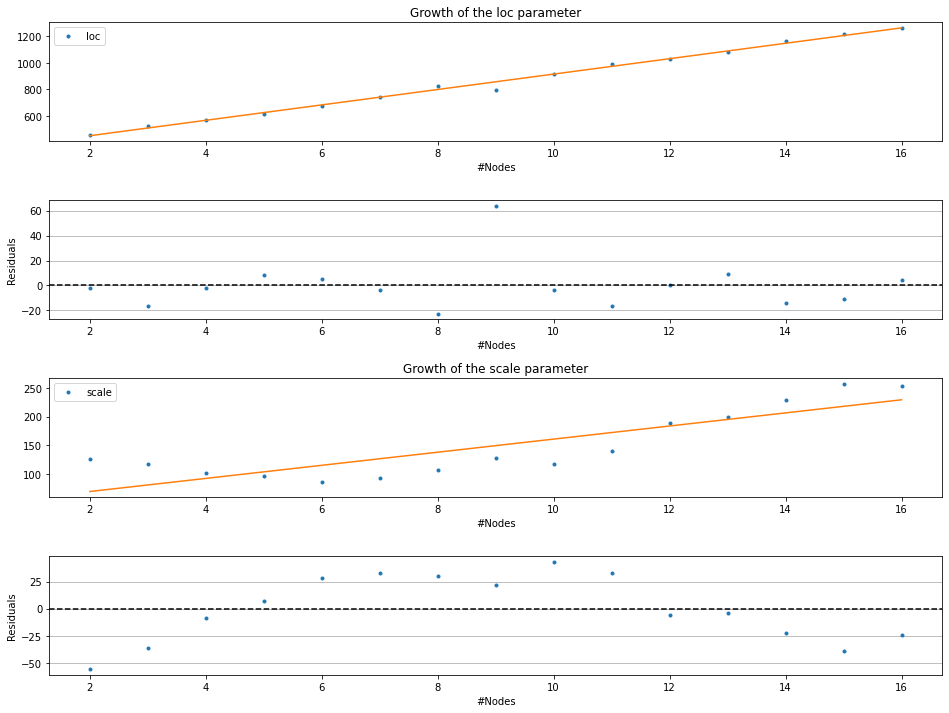

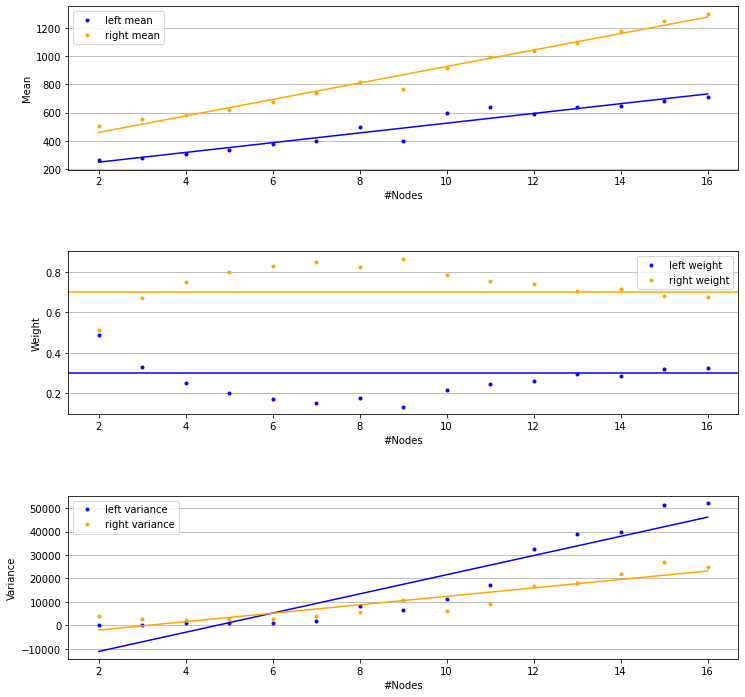

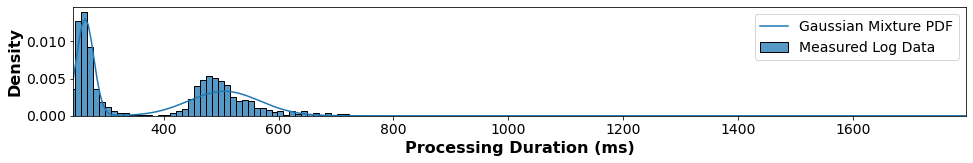

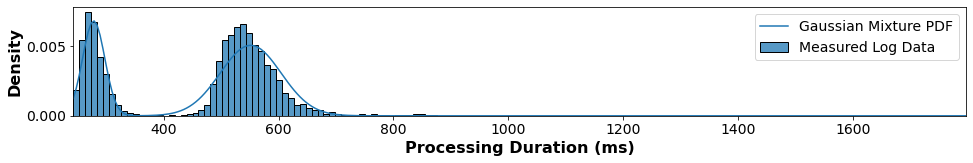

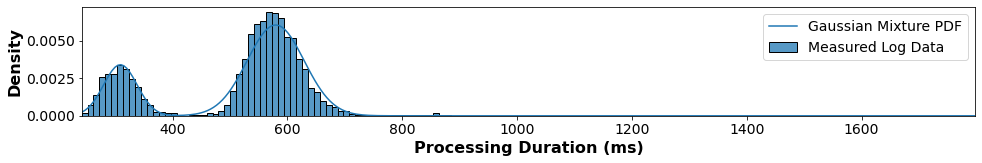

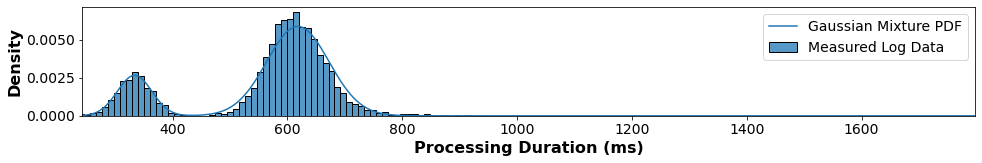

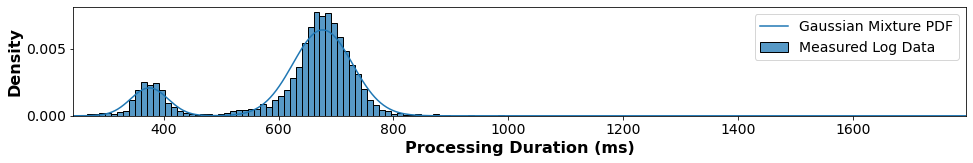

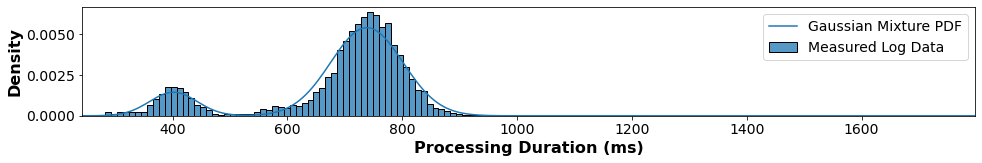

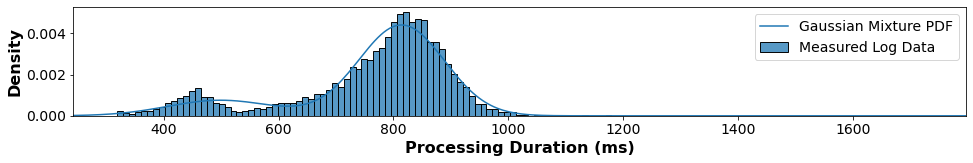

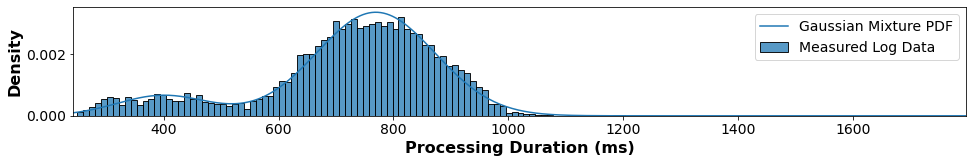

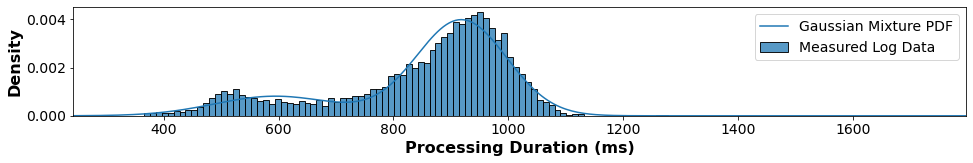

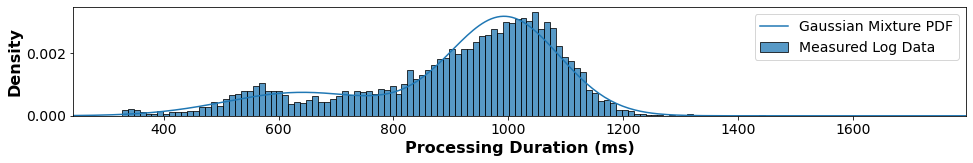

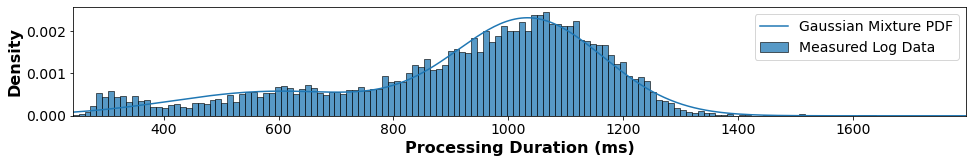

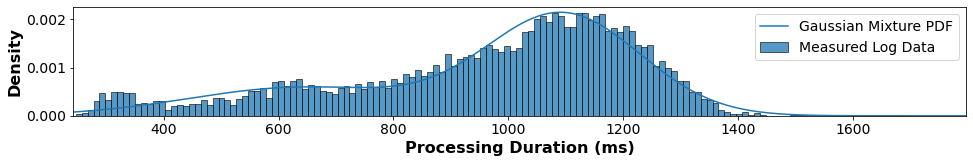

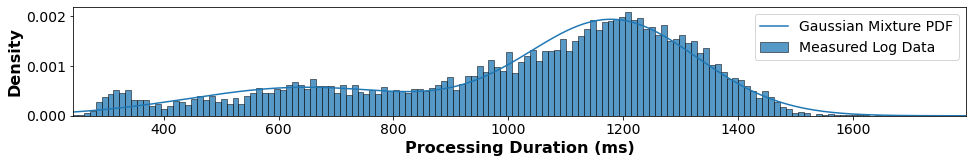

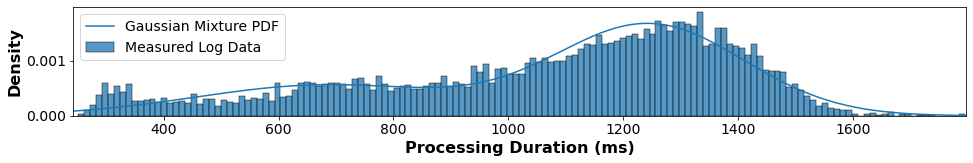

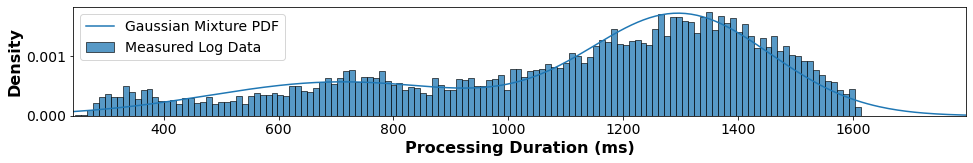

In [14]:
#jp_consensus_process_proposal.csv
#jp_consensus_process_new_round.csv
#jp_consensus_ensure_round_and_sync_up.csv
#jp_consensus_process_proposal_without_sync.csv
                                         
frame_number = 0

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = np.mean(data) - 1*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 2*np.std(data)
x_axis_range = xlim_end - xlim_start

a_list = []; loc_list = [] ;scale_list = []
means_1 = []; weights_1 = []; variances_1 = []
means_2 = []; weights_2 = []; variances_2 = []
loggamma_models = []; gaussian_mixtures_models = []
cleaned_data = []
p_cleaned = []; nr_samples = []; p_values = []
for index in range(len(experiment_type)):
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    #fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    
    #fig2, (ax2) = plt.subplots(1,1,figsize=(16,4))
    #sns.boxplot(data=data.to_numpy(), ax=ax2)
    
    # Let the network warm up and start to measure after warm up
    #data = data[round(0.3*len(data)):]

    # Clean the data
    # The data cannot have outlier behaviour or else the fitting is bad
    data_start = len(data)
    #Scale in the #nodes
    data = data[data.between(data.quantile(0), data.quantile(.97))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    cleaned_data.append(data)
    
    # Plot the data in buckets
    #sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    #sns.histplot(data, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    
    # Loggamma modeling BEGIN
    a, loc, scale = stats.loggamma.fit(data, f0=1) #15
    #print("a=" + str(a) + ", loc=" + str(loc) + ", scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    gamma_fit = stats.loggamma(a, loc, scale)
    loggamma_models.append(gamma_fit)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)[1]

    # Plotting the Loggamma distribution
    X = np.linspace(xlim_start, xlim_end, 300)
    #ax0.plot(X, gamma_fit.pdf(X), label="Loggamma PDF")
    # Loggamma modeling END
    
    # Gaussian Mixture modeling BEGIN
    data_gaussian = data.values.reshape(-1,1)
    model = mixture.GaussianMixture(n_components=2)
    model.fit(data_gaussian)
    gaussian_mixtures_models.append(model)
    data_samples = model.sample(len(data_gaussian))
    
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    # Gaussian Mixture modeling END

    #print('#nodes = ' + str(index+2))
    p_value = stats.ks_2samp(np.array(data_gaussian).flatten(), data_samples[0].flatten())
    p_values.append(p_value[1])
    #print('P-value(Gaussian Mixture models) = ' + str(p_value[1]))
    #print('P-value(Loggamma) = ' + str(p_gamma_fit))
    p_cleaned_data = (data_start-data_end)/data_start*100
    p_cleaned.append(p_cleaned_data)
    nr_samples.append(data_end)
    #print("Percentage of data cleaned: " + str(p_cleaned_data) + ", #samples: " + str(data_end))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
    # For plotting the means, weights and variances of the gaussian mixture models
    if model.means_[0][0] < model.means_[1][0]:
        means_1.append(model.means_[0][0])
        weights_1.append(model.weights_[0])
        variances_1.append(model.covariances_[0][0][0])
        means_2.append(model.means_[1][0])
        weights_2.append(model.weights_[1])
        variances_2.append(model.covariances_[1][0][0])
    else:
        means_1.append(model.means_[1][0])
        weights_1.append(model.weights_[1])
        variances_1.append(model.covariances_[1][0][0])
        means_2.append(model.means_[0][0])
        weights_2.append(model.weights_[0])
        variances_2.append(model.covariances_[0][0][0])
        
    # Plot the PDF
    norm_params = np.array([[means_1[-1], math.sqrt(variances_1[-1])],
                            [means_2[-1], math.sqrt(variances_2[-1])]])
    
    xs = np.linspace(300, 900, 300)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, [weights_1[-1], weights_2[-1]]):
        ys += stats.norm.pdf(xs, loc=l, scale=s) * w
    #ax0.plot(xs, ys, label='Gaussian Mixture PDF')
    #ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    #ax0.legend()
    #plt.show()
    
# Plot the loc and scale parameters and perform linear fit
print()
print("Loggamma loc and scale model parameters:")
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
print(coefficients_loc)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
print(coefficients_scale)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')
print("R2 score (loc): " + str(r2_score(loc_list, poly_loc(range(2, len(loc_list)+2)))))

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')
print("R2 score (scale): " + str(r2_score(scale_list, poly_scale(range(2, len(scale_list)+2)))))

# Plot the gaussian mixture models
# Means
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(12,12), gridspec_kw={'hspace':0.5})
ax0.plot(range(2, len(means_1)+2), means_1, '.', color="blue", label="left mean")
ax0.plot(range(2, len(means_2)+2), means_2, '.', color="orange", label="right mean")
ax0.set_xlabel('#Nodes')
ax0.set_ylabel('Mean')
ax0.grid(axis='y')
ax0.legend()
# Weights
ax1.plot(range(2, len(weights_1)+2), weights_1, '.', color="blue", label="left weight")
ax1.plot(range(2, len(weights_2)+2), weights_2, '.', color="orange", label="right weight")
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Weight')
ax1.grid(axis='y')
ax1.legend()
# Variances
ax2.plot(range(2, len(variances_1)+2), variances_1, '.', color="blue", label="left variance")
ax2.plot(range(2, len(variances_2)+2), variances_2, '.', color="orange", label="right variance")
ax2.set_xlabel('#Nodes')
ax2.set_ylabel('Variance')
ax2.grid(axis='y')
ax2.legend()

# Fit Means, Weights and variances into a linear model
# Means
coefficients_mean_1 = np.polyfit(range(2, len(means_1)+2), means_1, 1)
coefficients_mean_2 = np.polyfit(range(2, len(means_2)+2), means_2, 1)
poly_mean_1 = np.poly1d(coefficients_mean_1)
poly_mean_2 = np.poly1d(coefficients_mean_2)
ax0.plot(range(2, len(means_1)+2), poly_mean_1(range(2, len(means_1)+2)), color="blue", label="left weight model")
ax0.plot(range(2, len(means_2)+2), poly_mean_2(range(2, len(means_1)+2)), color="orange", label="right weight model")
print("Gaussian mixture model parameters:")
print("Mean1: " + str(coefficients_mean_1) + " R^2 score (left): " + str(r2_score(means_1, poly_mean_1(range(2, len(means_1)+2)))))
print("Mean2: " + str(coefficients_mean_2) + " R^2 score (right): " + str(r2_score(means_2, poly_mean_2(range(2, len(means_2)+2)))))

# Weights
ax1.axhline(y=.3, color="blue")
ax1.axhline(y=.7, color="orange")

#Variances
coefficients_variance_1 = np.polyfit(range(2, len(variances_1)+2), variances_1, 1)
coefficients_variance_2 = np.polyfit(range(2, len(variances_2)+2), variances_2, 1)
poly_variance_1 = np.poly1d(coefficients_variance_1)
poly_variance_2 = np.poly1d(coefficients_variance_2)
ax2.plot(range(2, len(variances_1)+2), poly_variance_1(range(2, len(variances_1)+2)), color="blue", label="left variance model")
ax2.plot(range(2, len(variances_2)+2), poly_variance_2(range(2, len(variances_2)+2)), color="orange", label="right variance model")
print("Variance1: " + str(coefficients_variance_1) + " R^2 score (left): " + str(r2_score(variances_1, poly_variance_1(range(2, len(variances_1)+2)))))
print("Variance2: " + str(coefficients_variance_2) + " R^2 score (right): " + str(r2_score(variances_2, poly_variance_2(range(2, len(variances_2)+2)))))

# Plot the models

for index in range(len(experiment_type)):
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))
    # Plot the data in buckets
    sns.histplot(cleaned_data[index], ax=ax0, stat="density", label="Measured Log Data", binwidth=x_axis_range/150)
    #sns.histplot(cleaned_data[index], ax=ax1, stat="density", label="Measured Log Data", binwidth=x_axis_range/150)
    # Plotting the Loggamma PDF
    X = np.linspace(xlim_start, xlim_end, 300)
    #ax0.plot(X, loggamma_models[index].pdf(X), label="Loggamma PDF")
    # Plotting the Gaussian Mixtures PDF
    norm_params = np.array([[means_1[index], math.sqrt(variances_1[index])],
                            [means_2[index], math.sqrt(variances_2[index])]])
    xs = np.linspace(xlim_start, xlim_end, 300)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, [weights_1[index], weights_2[index]]):
        ys += stats.norm.pdf(xs, loc=l, scale=s) * w
    ax0.plot(xs, ys, label='Gaussian Mixture PDF')
    
    # Plotting the loggamma model PDF
    loc = poly_loc(index + 2)
    scale = poly_scale(index + 2)
    loggamma_predicted_fit = stats.loggamma(1, loc, scale)
    #ax1.plot(X, loggamma_predicted_fit.pdf(X), label='Predicted Loggamma model PDF')
    
    # Plotting the Predicted Gaussian Mixtures model PDF
    mean1 = poly_mean_1(index + 2)
    mean2 = poly_mean_2(index + 2)
    std1 = poly_variance_1(index + 2)
    std2 = poly_variance_2(index + 2)
    if std1 < 15:
        std1 = 15
    if std2 < 15:
        std2 = 15
    
    norm_params = np.array([[mean1, math.sqrt(std1)],
                            [mean2, math.sqrt(std2)]])
    xs = np.linspace(xlim_start, xlim_end, 300)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, [weights_1[index], weights_2[index]]):
        ys += stats.norm.pdf(xs, loc=l, scale=s) * w
    #ax1.plot(xs, ys, label='Predicted Gaussian Mixture model PDF')
    # Print statistics
    #print('#nodes = ' + str(index+2))
    p_loggamma_fit = stats.kstest(cleaned_data[index], loggamma_models[index].cdf)[1]
    p_loggamma_predicted_fit = stats.kstest(cleaned_data[index], loggamma_predicted_fit.cdf)[1]
    #print('P-value(Loggamma) = ' + str(p_loggamma_fit))
    #print('P-value(Predicted Loggamma) = ' + str(p_loggamma_predicted_fit))
    
    data_samples = gaussian_mixtures_models[index].sample(len(cleaned_data[index]))
    #data_samples_pred = gaussian_mixtures_models[index].sample(len(cleaned_data[index]))
    p_value = stats.ks_2samp(np.array(cleaned_data[index].values.reshape(-1,1)).flatten(), data_samples[0].flatten())
    #p_value_pred = stats.ks_2samp(np.array(cleaned_data[index].values.reshape(-1,1)).flatten(), data_samples[0].flatten())
    #print('P-value(Gaussian Mixture) = ' + str(p_value[1]))
    #print('P-value(Predicted Gaussian Mixture) = ' + str(p_value_pred[1]))
        
    # Set the plots limits and legend
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    ax0.set_xlabel('Processing Duration (ms)', fontweight='bold')
    ax0.set_ylabel('Density', fontweight='bold')
    
    ax0.xaxis.label.set_size(16)
    ax0.yaxis.label.set_size(16)
    ax0.xaxis.set_tick_params(labelsize=14)
    ax0.yaxis.set_tick_params(labelsize=14)
    
    ax0.legend(fontsize=14)
    #ax1.legend()
    plt.show()

In [8]:
print('%data removed')
for x in p_cleaned:
    print(round(x,2))
print('#samples')
for x in nr_samples:
    print(round(x,2))
print('weights_left')
for x in weights_1:
    print(round(x,2))
print('weights_right')
for x in weights_2:
    print(round(x,2))
print('mean_left')
for x in means_1:
    print(round(x,2))
print('mean_right')
for x in means_2:
    print(round(x,2))
print('var_left')
for x in variances_1:
    print(round(x,2))
print('var_right')
for x in variances_2:
    print(round(x,2))
print('P-value')
for x in p_values:
    print(round(x,2))

%data removed
3.03
3.44
4.12
3.49
3.76
4.3
4.82
4.04
5.53
5.02
3.97
3.98
4.65
3.19
3.03
#samples
2175
3788
4794
5250
5938
6562
7066
7860
8201
8053
8909
8959
9008
8973
8102
weights_left
0.49
0.33
0.25
0.2
0.17
0.15
0.18
0.13
0.21
0.25
0.26
0.29
0.29
0.32
0.32
weights_right
0.51
0.67
0.75
0.8
0.83
0.85
0.82
0.87
0.79
0.75
0.74
0.71
0.71
0.68
0.68
mean_left
263.1
278.02
308.95
333.79
374.9
401.66
501.47
397.67
593.76
641.54
595.14
640.74
644.8
686.57
707.28
mean_right
505.1
551.38
579.44
618.12
676.76
738.32
814.69
769.08
918.36
994.32
1036.96
1094.98
1181.38
1248.36
1298.81
var_left
222.92
373.48
849.61
897.6
1060.54
1750.46
8823.15
6240.57
11095.74
17607.01
32886.5
39018.72
40222.55
52154.32
51945.14
var_right
3883.65
2814.61
2467.31
2937.08
2687.72
3941.18
5527.15
10686.1
6194.64
8992.28
16520.27
18031.75
21922.15
26667.28
25030.85
P-value
0.0
0.0
0.0
0.0
0.0
0.0
0.05
0.03
0.0
0.03
0.17
0.02
0.06
0.05
0.03


#nodes = 2
a=2.3768714082392632, loc=202.9680472509433, scale=37.9108460524862
(array(293.0772533), array(3416.11623826))


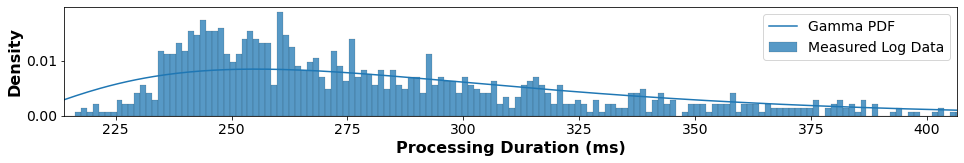

P-value(gamma) = KstestResult(statistic=0.08691860638237375, pvalue=7.984272828841586e-08)
Percentage of data cleaned: 0.0, #samples: 1122
#nodes = 3
a=3.3539806809735238, loc=225.67861731120774, scale=23.10250608842814
(array(303.16397641), array(1790.10598043))


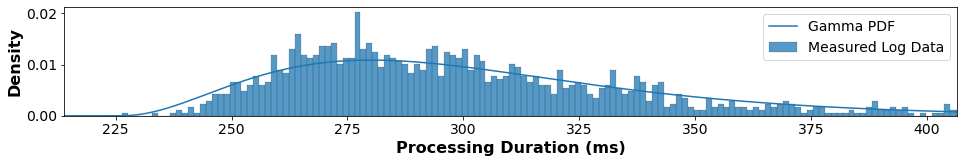

P-value(gamma) = KstestResult(statistic=0.04377354303970327, pvalue=0.012760332164226887)
Percentage of data cleaned: 0.0, #samples: 1311
#nodes = 4
a=4.642931153982577, loc=225.33118464912775, scale=14.112150643628933
(array(290.85292852), array(924.65271997))


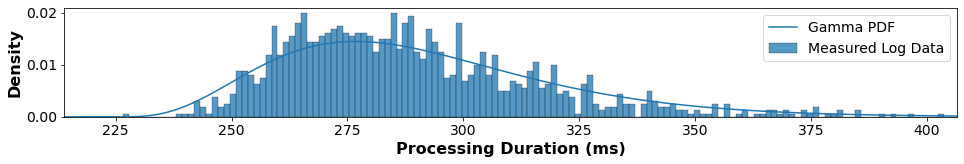

P-value(gamma) = KstestResult(statistic=0.0485648933615378, pvalue=0.0052379438583489875)
Percentage of data cleaned: 0.0, #samples: 1253
#nodes = 5
a=0.026451276791122635, loc=219.75799999999998, scale=11.908928904688093
(array(220.07300637), array(3.75138852))


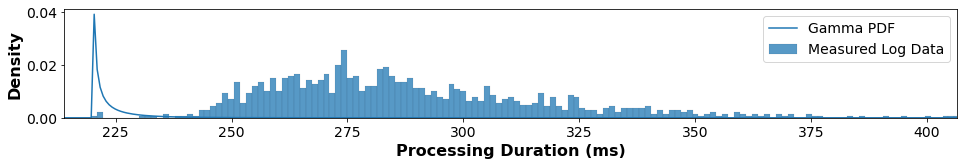

P-value(gamma) = KstestResult(statistic=0.9900269166212186, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 1091
#nodes = 6
a=8.783309670942423, loc=197.6656678210053, scale=9.674464161906638
(array(282.63948246), array(822.07612438))


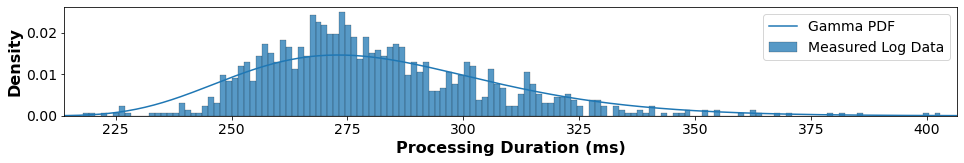

P-value(gamma) = KstestResult(statistic=0.0704542126639548, pvalue=6.716990413770636e-05)
Percentage of data cleaned: 0.0, #samples: 1032
#nodes = 7
a=0.001252283862423903, loc=59.285, scale=4.150603332702449
(array(59.29019773), array(0.02157373))


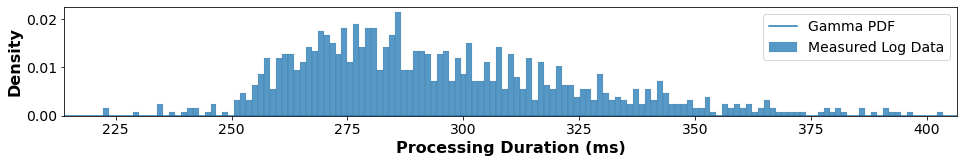

P-value(gamma) = KstestResult(statistic=0.9985910463894091, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 984
#nodes = 8
a=7.235575824433991, loc=213.15823373547698, scale=13.236686557145838
(array(308.93328298), array(1267.7443069))


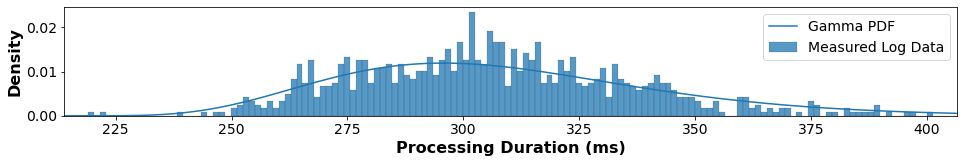

P-value(gamma) = KstestResult(statistic=0.05619611830599247, pvalue=0.005334283657935481)
Percentage of data cleaned: 0.0, #samples: 932
#nodes = 9
a=0.002594937376291761, loc=60.31699999999999, scale=4.739738388619519
(array(60.32929932), array(0.05829558))


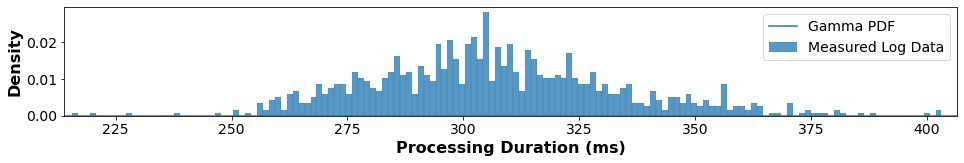

P-value(gamma) = KstestResult(statistic=0.9988877348105671, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 914
#nodes = 10
a=8.906419606540519, loc=201.25633212045227, scale=10.189185983381963
(array(292.00549794), array(924.66012835))


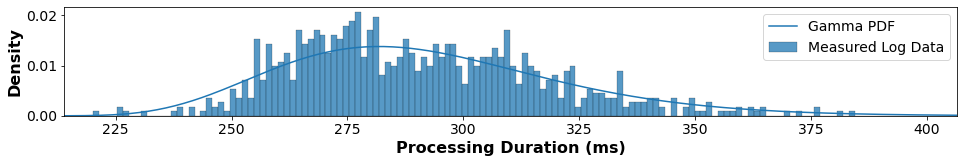

P-value(gamma) = KstestResult(statistic=0.04178381401416976, pvalue=0.09319448900541905)
Percentage of data cleaned: 0.0, #samples: 870
#nodes = 11
a=0.004918863059899029, loc=218.62099999999998, scale=4.863831196820405
(array(218.64492452), array(0.11636482))


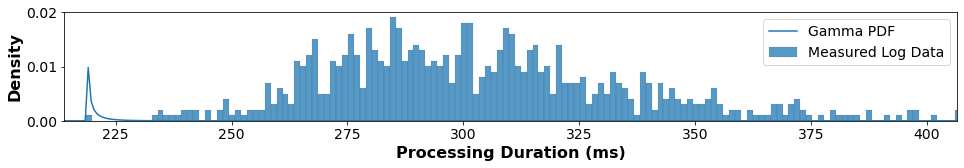

P-value(gamma) = KstestResult(statistic=0.9986503700821721, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 774
#nodes = 12
a=0.0022107203813097756, loc=59.681, scale=13.586554900382774
(array(59.71103607), array(0.40808677))


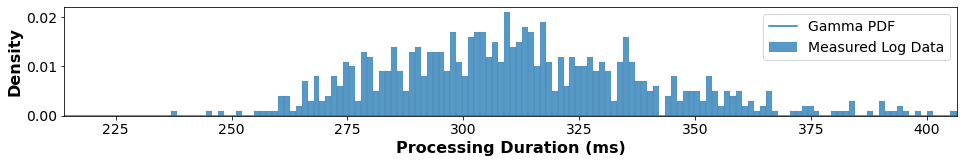

P-value(gamma) = KstestResult(statistic=0.9932269569469778, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 779
#nodes = 13
a=0.0043562246592234915, loc=56.42699999999999, scale=3.567761306438955
(array(56.44254197), array(0.05545004))


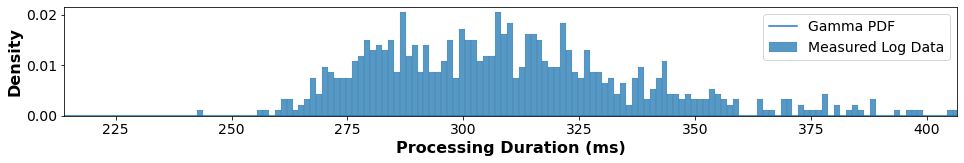

P-value(gamma) = KstestResult(statistic=0.9944562245657438, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 723
#nodes = 14
a=50.96319638950075, loc=-214.4196709946608, scale=10.415259862088298
(array(316.3752628), array(5528.367169))


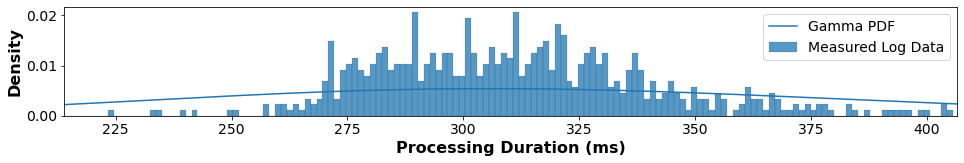

P-value(gamma) = KstestResult(statistic=0.21504229011968504, pvalue=4.427013423270952e-28)
Percentage of data cleaned: 0.0, #samples: 680
#nodes = 15
a=0.025413210946523615, loc=52.57299999999999, scale=1.802499088050313
(array(52.61880729), array(0.0825676))


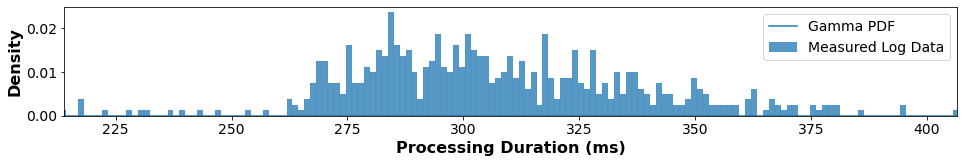

P-value(gamma) = KstestResult(statistic=0.9982750180657095, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 626
#nodes = 16
a=0.004334545129343113, loc=55.32899999999999, scale=2.973924641715014
(array(55.34189061), array(0.0383357))


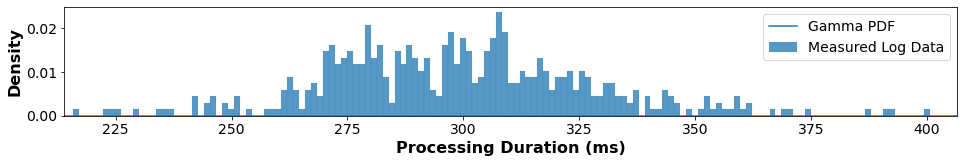

P-value(gamma) = KstestResult(statistic=0.9976086286430397, pvalue=0.0)
Percentage of data cleaned: 0.0, #samples: 526
[-17.96917578 283.9645428 ]
[-1.47890139 24.3924419 ]


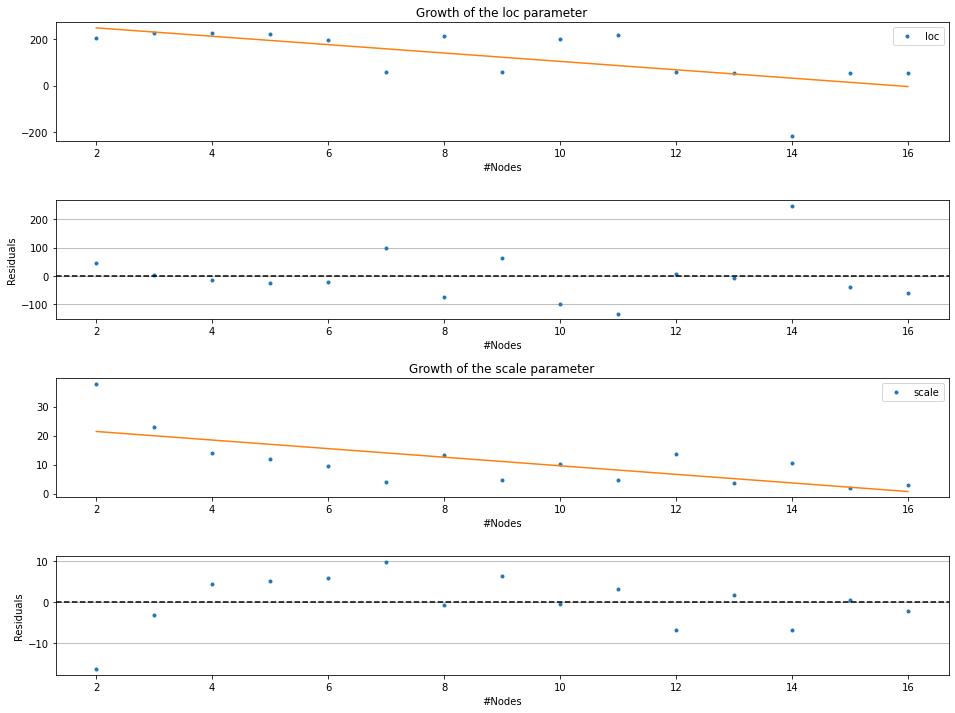

In [16]:
#jp_consensus_process_proposal.csv
#jp_consensus_process_new_round.csv
#jp_consensus_ensure_round_and_sync_up.csv
#jp_consensus_process_proposal_without_sync.csv
frame_number = 1

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = np.mean(data) - 1*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 2*np.std(data)
x_axis_range = xlim_end - xlim_start

a_list = []
loc_list = []
scale_list = []
p_cleaned = []; nr_samples = []; p_values = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    #remove first 20% of the data
    #data = data[round(0.4*len(data)):round(0.9*len(data))]
    #data = data[round(0.3*len(data)):]

    #Clean the data a bit
    data_start = len(data)
    #Scale in the #nodes
    #data = data[data.between(data.quantile(0.02), data.quantile(.98))]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    #data = data.values.reshape(-1,1)
    #model = mixture.GaussianMixture(n_components=2)
    #model.fit(data)
    #data_samples = model.sample(len(data))
    
    #GAMMA TEST
    a, loc, scale = stats.gamma.fit(data) #15
    print("a=" + str(a) + ", loc=" + str(loc) + ", scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    
    gamma_fit = stats.gamma(a, loc, scale)
    print(gamma_fit.stats())
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #a, beta, loc, scale = stats.beta.fit(data, f0=30)
    #beta_fit = stats.beta(alpha, beta, loc, scale)
    #p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(xlim_start, xlim_end, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Gamma PDF")
    #ax0.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    #END GAMMA TEST

    sns.histplot(data, ax=ax0, stat="density", label="Measured Log Data", binwidth=x_axis_range/150)
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    ax0.set_xlabel('Processing Duration (ms)', fontweight='bold')
    ax0.set_ylabel('Density', fontweight='bold')
    ax0.legend()
    
    ax0.xaxis.label.set_size(16)
    ax0.yaxis.label.set_size(16)
    ax0.xaxis.set_tick_params(labelsize=14)
    ax0.yaxis.set_tick_params(labelsize=14)
    
    ax0.legend(fontsize=14)
    
    plt.show()

    #p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    #print('P-value = ' + str(p_value[1]))
    print('P-value(gamma) = ' + str(p_gamma_fit))
    p_values.append(p_gamma_fit[1])
    p_data_cleaned = (data_start-data_end)/data_start*100
    p_cleaned.append(p_data_cleaned)
    nr_samples.append(data_end)
    print("Percentage of data cleaned: " + str(p_data_cleaned) + ", #samples: " + str(data_end))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
# Plot the loc and scale parameters and perform linear fit
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
print(coefficients_loc)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
print(coefficients_scale)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')

In [43]:
print('%data removed')
for x in p_cleaned:
    print(round(x,2))
print('#samples')
for x in nr_samples:
    print(round(x,2))
print('a')
for x in a_list:
    print(round(x,2))
print('loc')
for x in loc_list:
    print(round(x,2))
print('scale')
for x in scale_list:
    print(round(x,2))
print('P-value')
for x in p_values:
    print(round(x,2))

%data removed
5.88
5.03
4.95
4.77
4.65
4.67
4.08
4.27
4.14
4.39
4.36
4.98
5.29
5.75
6.27
#samples
1056
1245
1191
1039
984
938
894
875
834
740
745
687
644
590
493
a
1.6
2.51
2.91
2.55
4.37
2.52
9.19
11.54
3.96
5.56
9.03
4.34
34.97
52.21
35.6
loc
227.7
243.82
245.65
242.47
235.5
248.45
223.17
221.49
239.98
232.96
228.5
252.16
132.86
83.89
115.89
scale
34.57
21.81
14.43
17.64
10.23
18.35
9.06
7.41
12.72
12.58
9.21
13.11
5.1
4.28
5.16
P-value
0.12
0.61
0.33
0.62
0.54
0.42
0.22
0.5
0.04
0.62
0.67
0.24
0.4
0.09
0.1


#nodes = 2
alpha=3
loc=170.83891615516592
scale=73.66987241397636


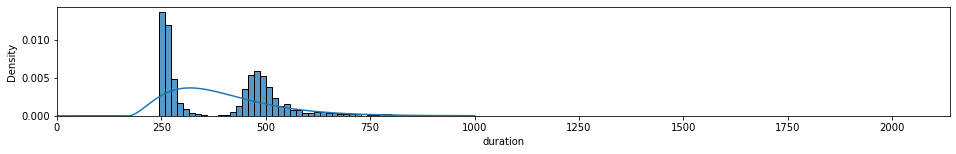

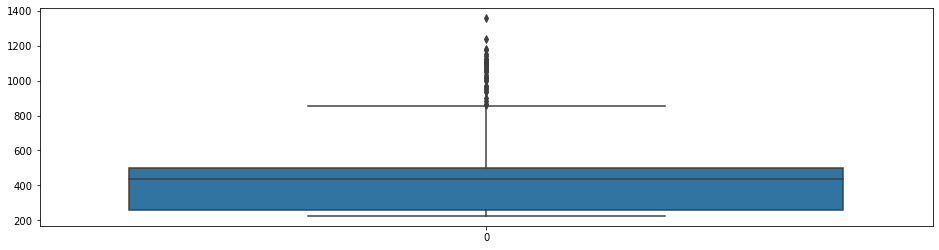

#nodes = 3
alpha=3
loc=182.3870698055404
scale=97.81786610533577


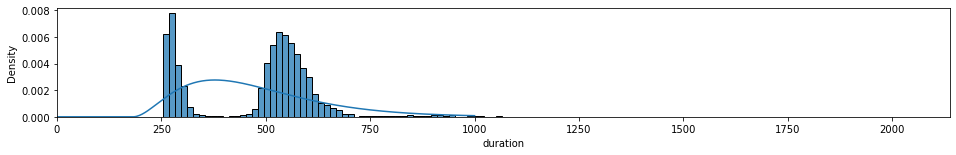

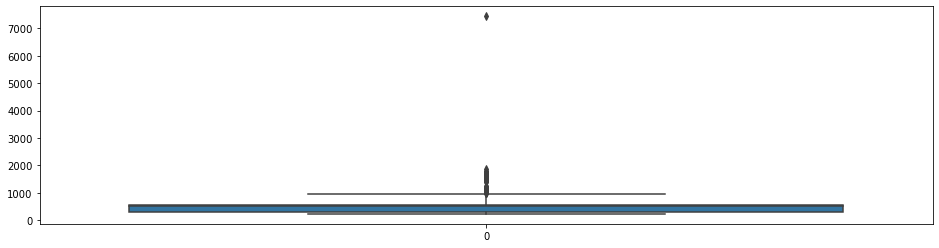

#nodes = 4
alpha=3
loc=228.73331783575105
scale=100.64293080414355


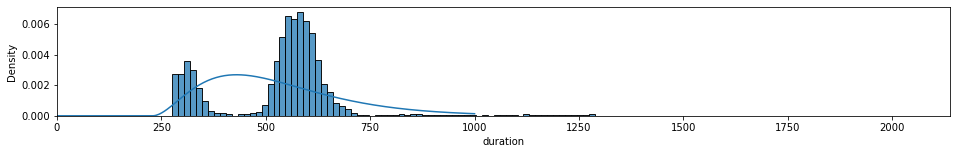

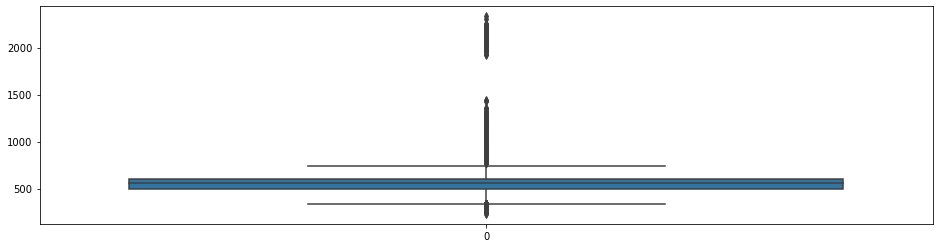

#nodes = 5
alpha=3
loc=262.6210956622471
scale=104.38451333241312


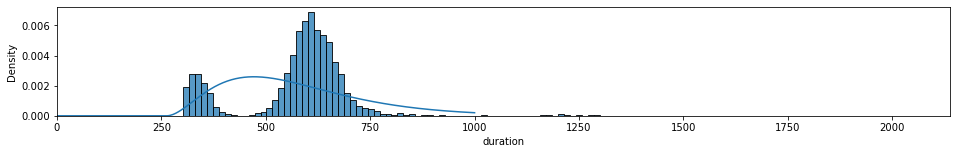

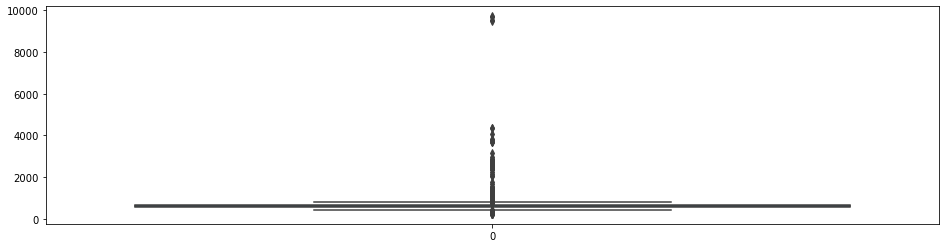

#nodes = 6
alpha=3
loc=312.91494061027515
scale=111.57309139792758


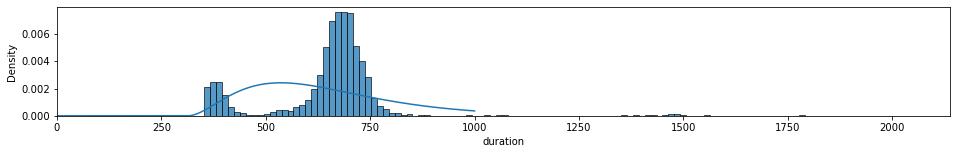

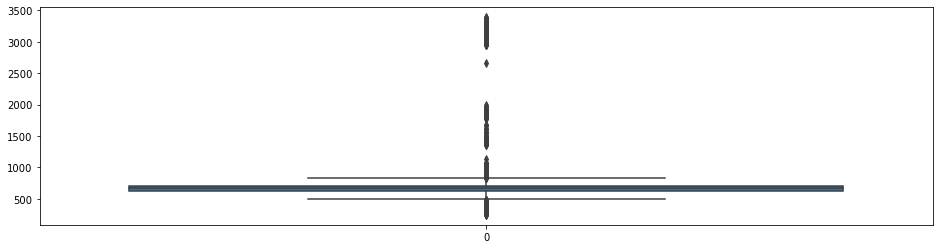

#nodes = 7
alpha=3
loc=333.9741725321242
scale=127.32835864645139


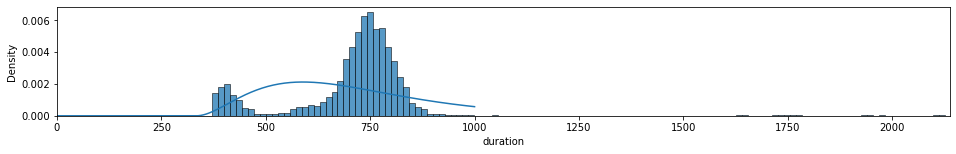

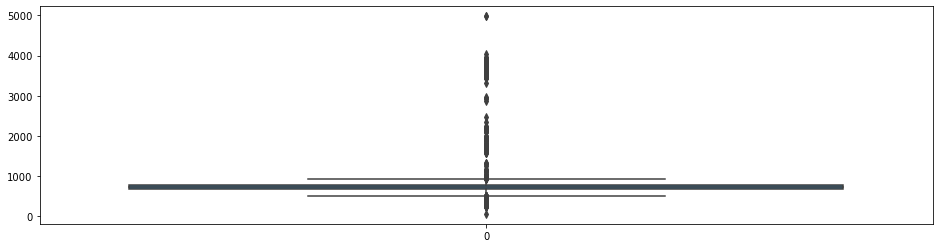

#nodes = 8
alpha=3
loc=377.9485108545623
scale=130.8061658996719


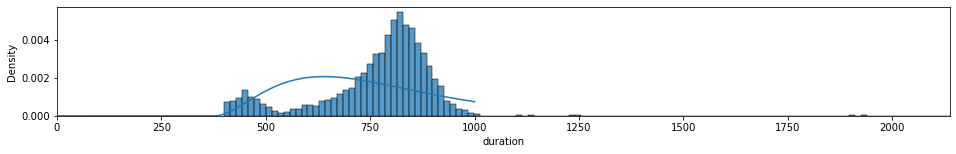

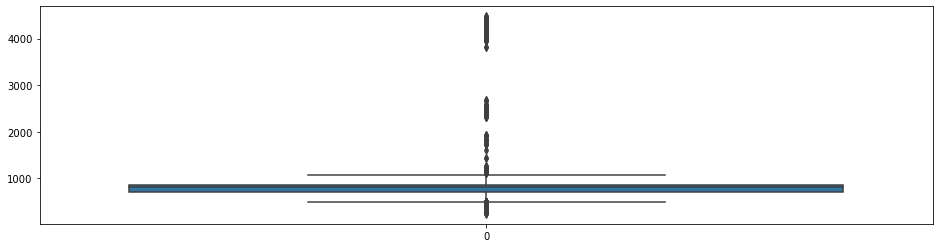

#nodes = 9
alpha=3
loc=323.10049864677524
scale=142.39607869543715


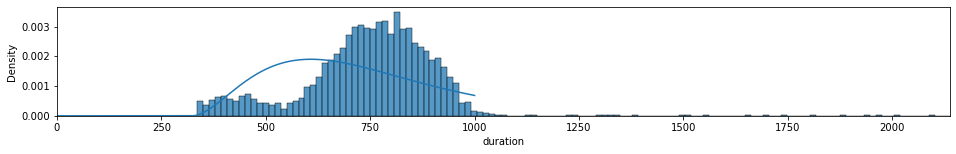

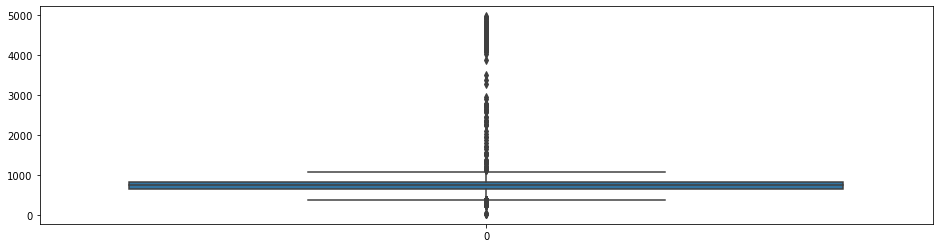

#nodes = 10
alpha=3
loc=411.141733090259
scale=146.4152182316081


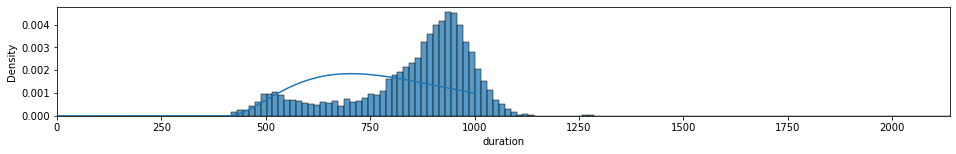

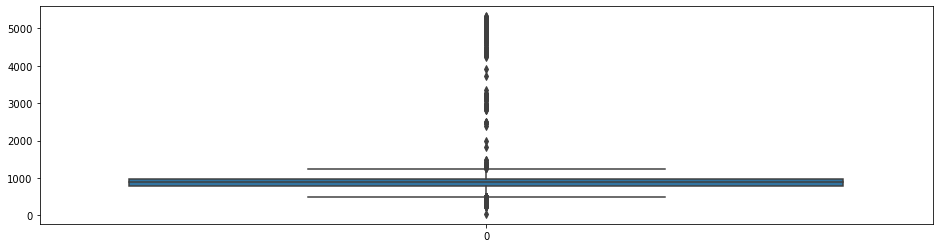

#nodes = 11
alpha=3
loc=447.5261694891501
scale=158.77534359343952


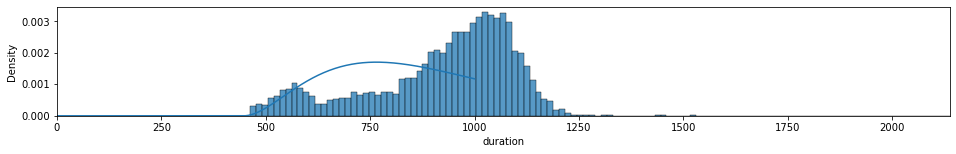

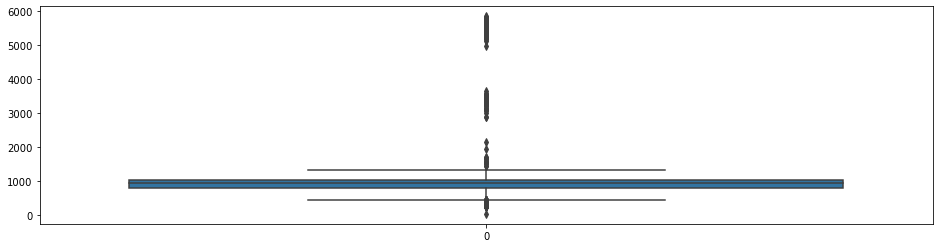

#nodes = 12
alpha=3
loc=343.1303238773012
scale=204.61061203975294


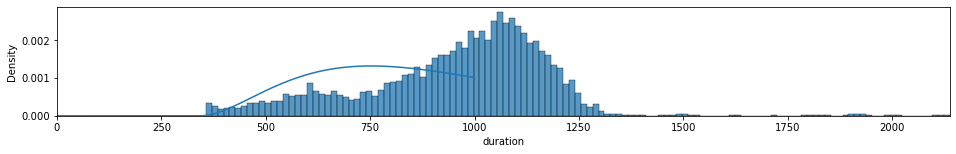

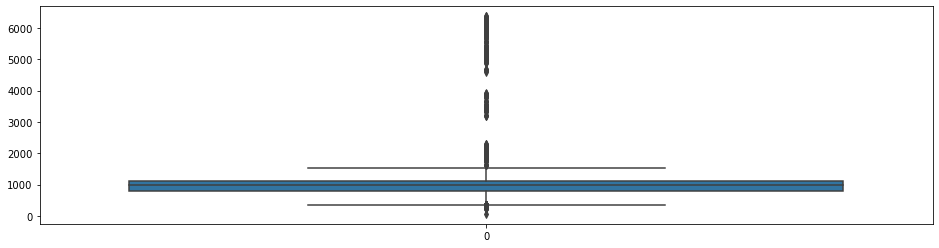

#nodes = 13
alpha=3
loc=340.67369208692674
scale=216.6549049319581


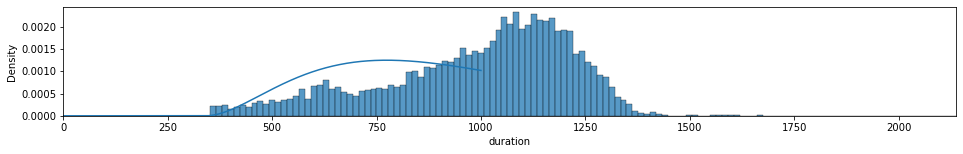

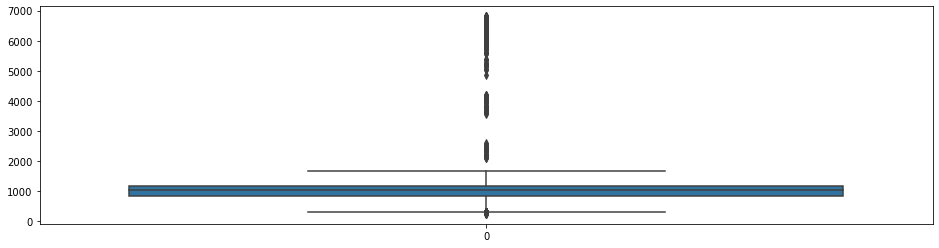

#nodes = 14
alpha=3
loc=320.07388168563335
scale=248.7019052233208


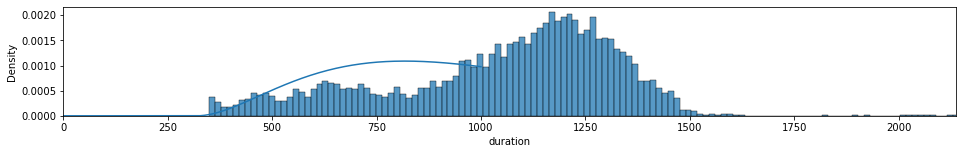

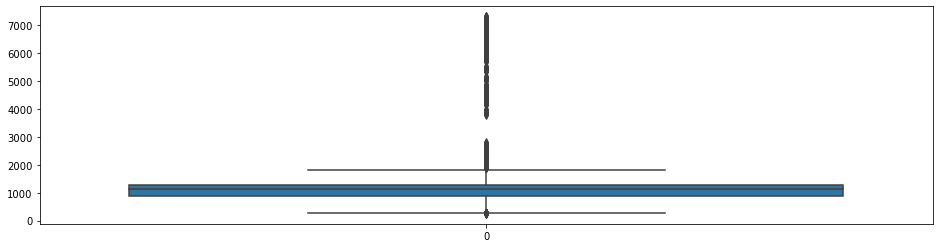

#nodes = 15
alpha=3
loc=335.34932441660493
scale=259.2905468120662


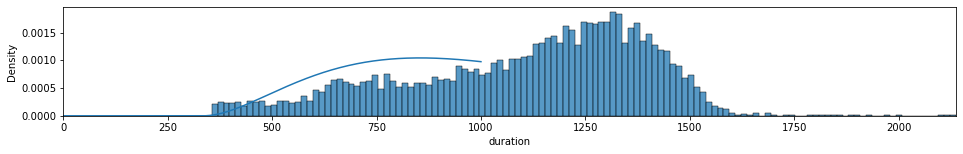

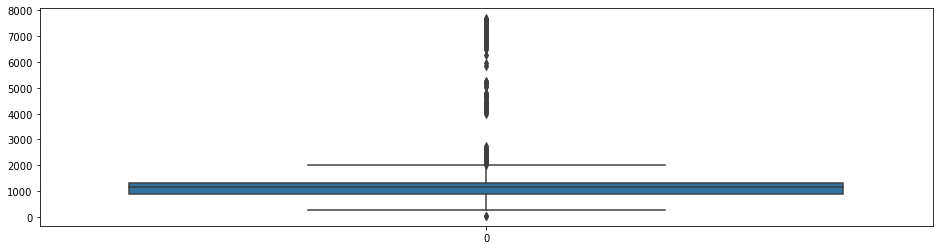

#nodes = 16
alpha=3
loc=348.65220472883266
scale=272.67666438812984


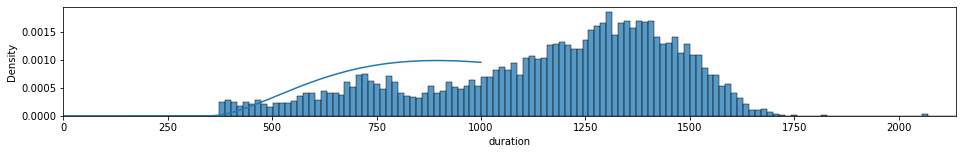

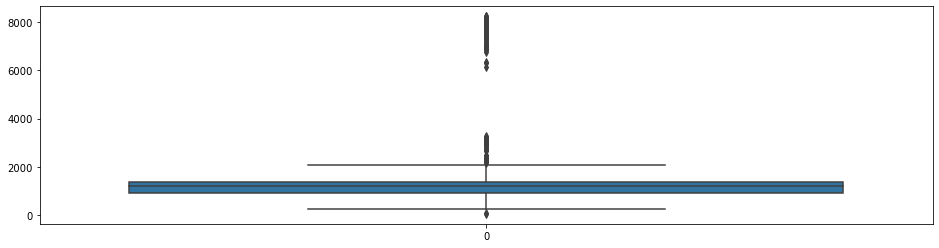

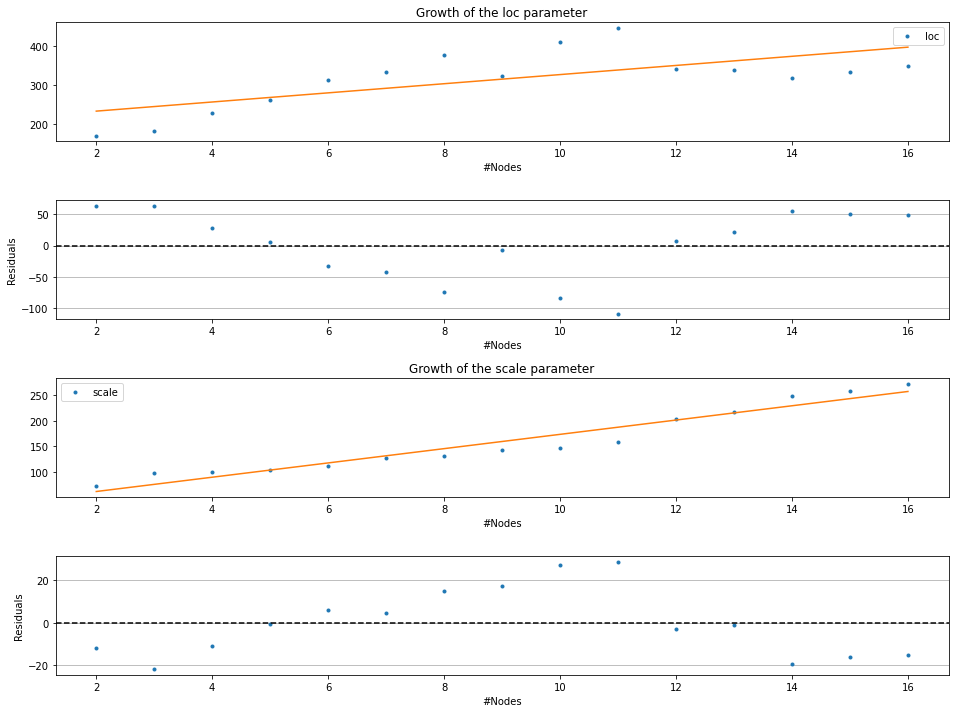

In [18]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 0

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = 0#np.mean(data) - 3*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 3*np.std(data)
x_axis_range = xlim_end - xlim_start

gamma_zipped_parameters = []
a_list = []
loc_list = []
scale_list = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    
    fig2, (ax2) = plt.subplots(1,1,figsize=(16,4))
    sns.boxplot(data=data.to_numpy(), ax=ax2)
    
    data = data[round(0.3*len(data)):]

    #Clean the data a bit
    data_start = len(data)
    data = data[data.between(data.quantile(0.03), data.quantile(.99))]
    #data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 2*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    #data = data.values.reshape(-1,1)

    #model = mixture.GaussianMixture(n_components=6)
    #model.fit(data)
    #data_samples = model.sample(len(data))
    
    #GAMMA TEST
    a, loc, scale = stats.gamma.fit(data, f0=3)
    print("alpha=" + str(a))
    print("loc=" + str(loc))
    print("scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    gamma_zipped = zip([a], [loc], [scale])
    gamma_zipped_parameters.append(gamma_zipped)
    
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #a, beta, loc, scale = stats.beta.fit(data, f0=30)
    #gamma_zipped = zip([a], [beta], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    #beta_fit = stats.beta(alpha, beta, loc, scale)
    #p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(0, 1000, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    #ax0.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    #END GAMMA TEST

    sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    plt.show()

    #p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    #print('P-value = ' + str(p_value[1]))
    #print('P-value(gamma) = ' + str(p_gamma_fit))
    #print("Percentage of data cleaned: " + str((data_start-data_end)/data_start*100))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
# Plot the loc and scale parameters and perform linear fit
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')

In [31]:
# Generate data for the gaussian mixture distribution
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data

In [115]:
# Calculate the parameters
weights = model.means_.flatten()
means = model.means_.flatten()
variances = model.covariances_.flatten()
zipped = zip(weights, means, variances)
print(list(zipped))

[(828.9474207536912, 828.9474207536912, 687.6968937923702), (738.2225297998947, 738.2225297998947, 1223.7490306989569)]


(0.0, 1000.0)

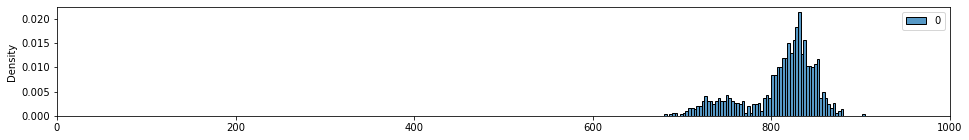

In [112]:
fig, (ax0) = plt.subplots(1,1,figsize=(16,2))

X = generate_data(1000, np.array([[742],[828]]), np.array([[[530]], [[415]]]), [.22,.78])

#model2 = mixture.GaussianMixture(n_components=2, weights_init=[.31,.69], means_init=[[389],[403]], precisions_init=[[[19]], [[17]]])
#data_samples = model2.sample(400)
sns.histplot(X, ax=ax0, stat="density", label="Real Data", binwidth=3)
ax0.set_xlim(0, 1000)

Gamma p score: KstestResult(statistic=0.3799212647523855, pvalue=1.5958773552583356e-38)
Beta p score: KstestResult(statistic=0.5016275700942059, pvalue=9.857065962144755e-69)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.39778766588729053, pvalue=2.7552032349691496e-97)
Beta p score: KstestResult(statistic=0.39965167503740584, pvalue=3.114608785998341e-98)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.41167485546279603, pvalue=5.544564689381867e-133)
Beta p score: KstestResult(statistic=0.41227309419181746, pvalue=2.1950765479098087e-133)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.41338875788830254, pvalue=1.7161279899477708e-172)
Beta p score: KstestResult(statistic=0.41341240296845716, pvalue=1.6367998827188505e-172)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.9786343595792448, pvalue=0.0)
Beta p score: KstestResult(statistic=0.38743435813471483, pvalue=4.1147595600794044e-17

IndexError: list index out of range

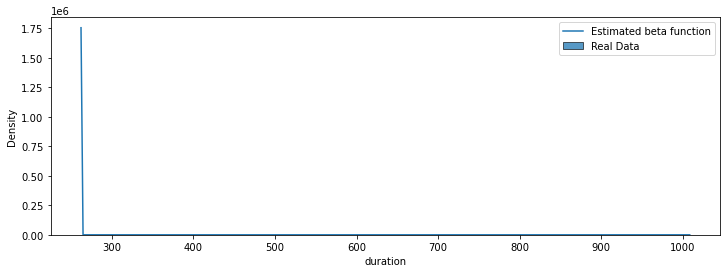

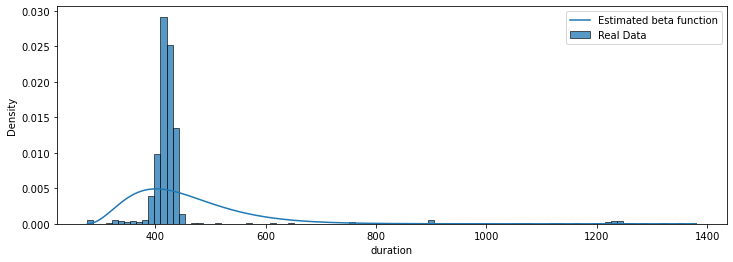

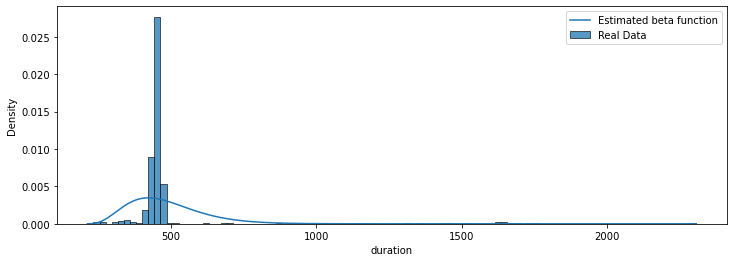

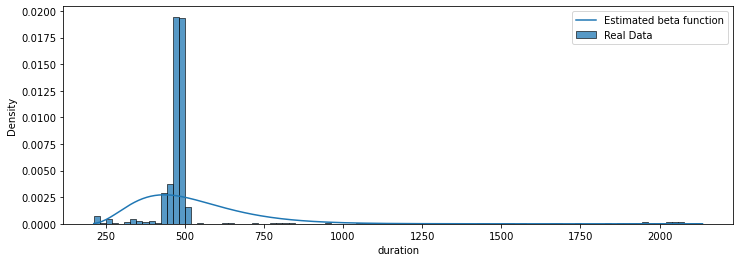

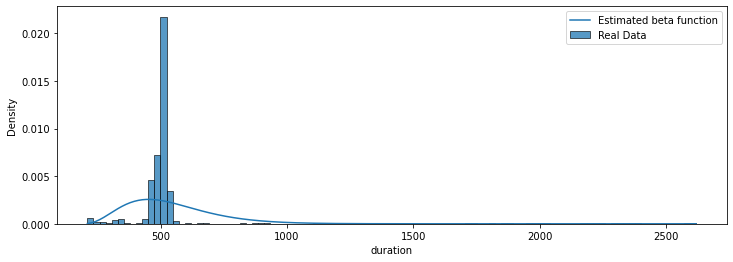

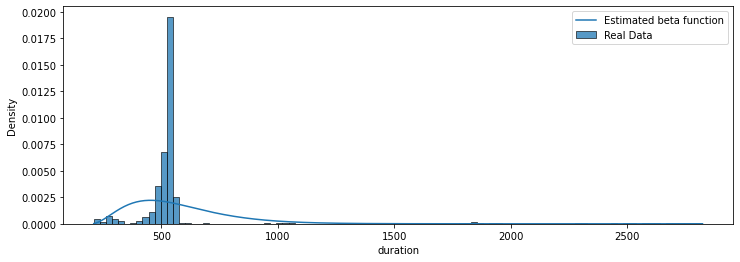

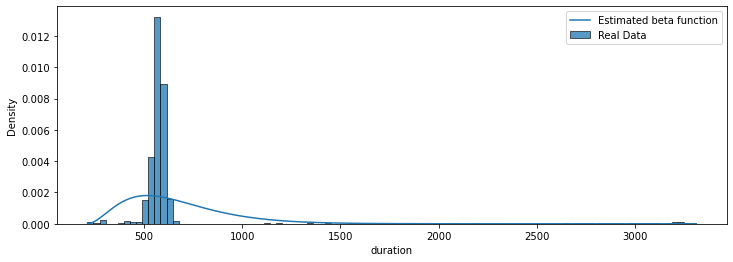

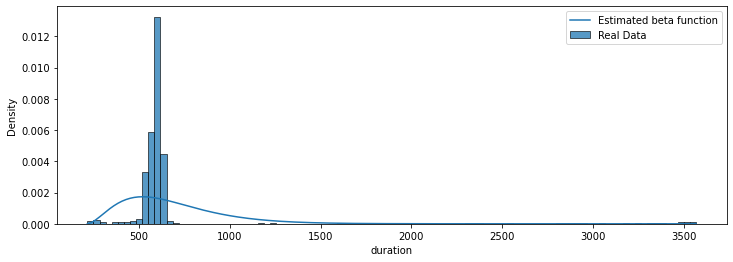

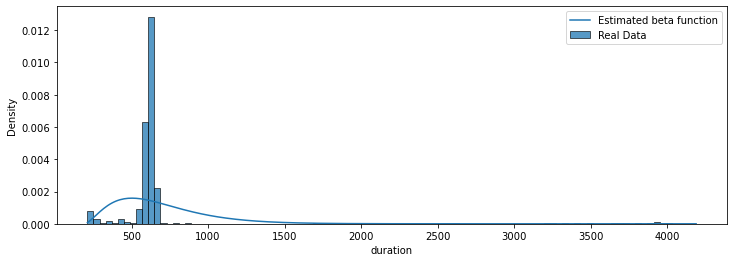

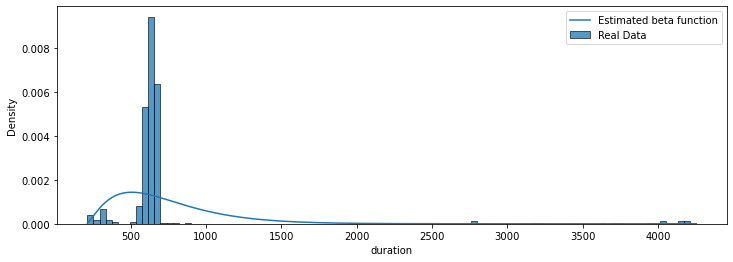

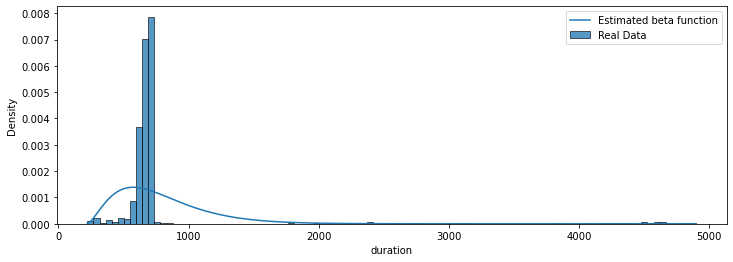

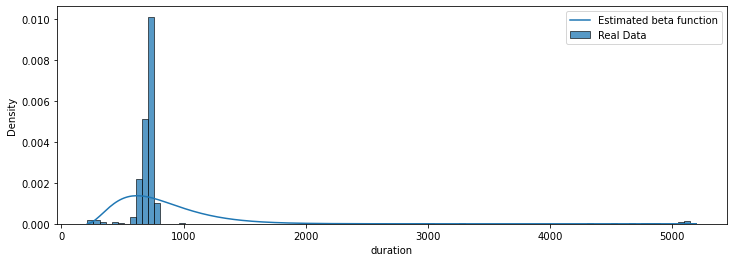

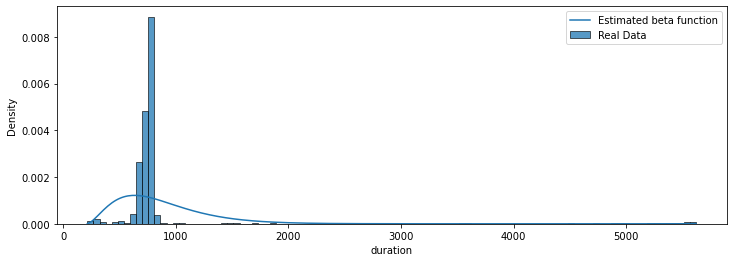

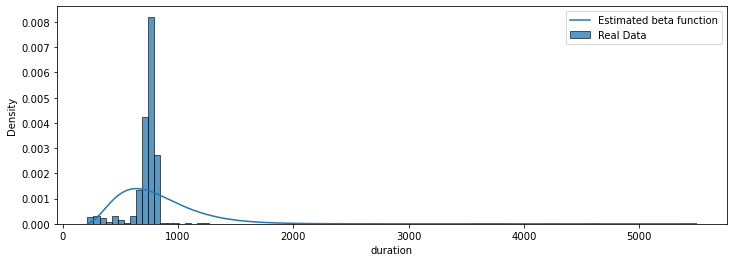

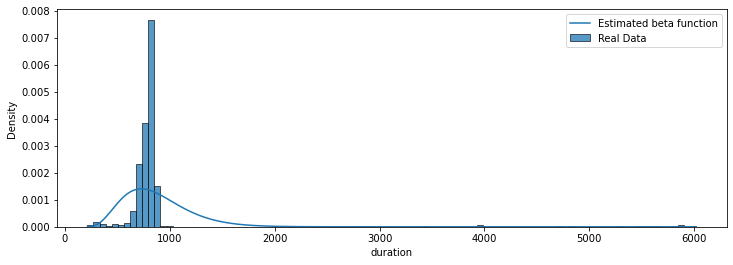

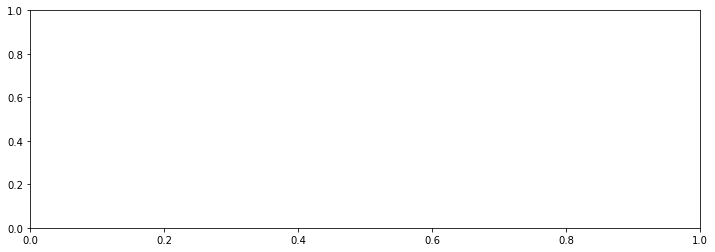

In [81]:
#0 = "/merged/jp_consensus_process_proposal.csv"
#1 = "/merged/jp_consensus_process_new_round.csv"
#2 = "/merged/jp_consensus_ensure_round_and_sync_up.csv"
#3 = "/merged/jp_consensus_process_proposal_without_sync.csv"


#Should work for 2,3 and 4
#Works for 2 and 4
frame_nr = 2
def plot_graphs(x):
    fig, ax = plt.subplots(figsize=(12,4))

    #data = data_frames[frame_nr + (x*len(tmp_frames))]['duration']
    data = data_frames[x*4 + frame_number]['duration']
    
    #data = data[round(0.2*len(data)):]

    #Clean the data a bit
    #data = data[data.between(data.quantile(.02), data.quantile(.99))]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]

    sns.histplot(data, ax=ax, stat="density", label="Real Data", bins=100)

    a, loc, scale = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    alpha, beta, loc, scale = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc, scale)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(min(data), max(data), 300)
    #ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    ax.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    ax.legend();

    print("Gamma p score: " + str(p_gamma_fit))
    print("Beta p score: " + str(p_beta_fit))
    print("Percentage of data cleaned: " + str((len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) - len(data)) / len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) * 100))
    
for x in range(0, 16):
    plot_graphs(x)